# Optimizing Classification Weights using Alpha-Loss



## Packages & libraries

In [559]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.optim as optim
import torch.nn as nn

In [560]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

## Helper Functions

In [561]:
def gmm_generator_function(N, n_min, Mu, Sigma):

  n_maj = N - n_min

  # initializes mean and covariance matrices for class +1
  A = Sigma
  b1_full = np.tile(Mu[0,:],(n_min,1)).T

  # initializes mean for class -1
  b2_full = np.tile(Mu[1,:],(n_maj,1)).T

  b_full = np.hstack((b1_full, b2_full))

  # generates random [2,N] matrix ~ N(0,1)
  np.random.seed(42)
  Z = np.random.randn(2,N)

  # convert ~N(0,1) random points to desired distributions 
  # via A*Z+b ~N(b, AA^T)
  X = np.dot(A,Z)+b_full

  # initialize vector with labels
  y1 = -np.ones((n_min,1))
  y2 = np.ones((n_maj,1))

  y = np.vstack((y1,y2))

  return X.T, y
 



In [562]:
def sigmoid(z):
  a = 1 + np.exp(-z)
  return 1/a

In [563]:
def alpha_loss_calc_torch(x_tensor, y_tensor, theta_1, theta_2, theta_3, alpha):

    X_tensor_1 = X_tensor[:,0]
    X_tensor_2 = X_tensor[:,1]
    X_tensor_1 = X_tensor_1.view(X_tensor_1.size(0),1)
    X_tensor_2 = X_tensor_2.view(X_tensor_2.size(0),1)

    X_T_theta = theta_1 + theta_2*X_tensor_1 + theta_3*X_tensor_2

    sig_tensor = (torch.special.expit(X_T_theta))

    if alpha == 1:
        t1 = y_tensor * torch.log(sig_tensor)
        t2 = (1-y_tensor) * torch.log(1-sig_tensor)
        torch_loss = -(t1 + t2)

    else:
        pow = 1-(1/alpha)
        sig_power_1 = torch.pow(sig_tensor, pow)
        sig_power_2 = torch.pow(1-sig_tensor, pow)       
        torch_loss = (alpha/(alpha-1))*(1 - y_tensor*sig_power_1 - (1-y_tensor)*sig_power_2)

    # with torch.no_grad():
    #     mean_loss = torch.mean(loss)

    # mean_loss = torch.mean(loss)
    mean_loss = torch.mean(torch_loss)
    return mean_loss

In [564]:
def alpha_loss(output,target,my_alpha):
    loss = 0
    if my_alpha == 1.0:
        loss = torch.mean(torch.sum(-target*torch.log(torch.softmax(output,dim=1) + 1e-8),dim=1))
    else:
        alpha = torch.FloatTensor([my_alpha]).cuda()
        one = torch.FloatTensor([1.0]).cuda()
        loss = (alpha/(alpha-one))*torch.mean(torch.sum(target*(one - torch.softmax(output,dim=1).pow(one - (one/alpha))),dim=1))
    return loss

In [565]:
from scipy.stats import multivariate_normal as norm
def posterior(x, p_y, mu_1, mu_2, sigma):
    return p_y * norm.pdf(x, mean=mu_1, cov = sigma) / (p_y * norm.pdf(x, mean=mu_1, cov = sigma) + (1-p_y)*norm.pdf(x,mean=mu_2, cov = sigma))

## Model parameters

## Generate GMM

500


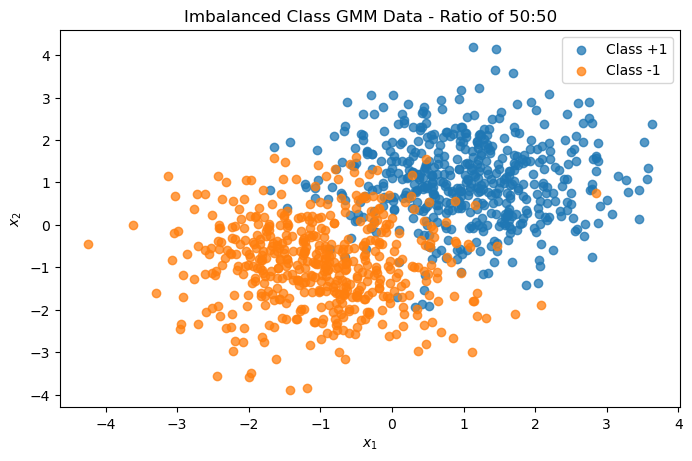

In [566]:
sigma = np.eye(2)
mu1 = -1
mu = np.array([[mu1, mu1], [-mu1, -mu1]])

N = 1000
M = 1000
m = 2
n_line = 100

# set the level of class imbalance
pmix = 0.5
mult = N/100
nmix = int(pmix*N)

# set the amount of label noise
pflip = 0.0

# generates GMM Data
[X,y] = gmm_generator_function(N,nmix,mu, sigma)

# add label noise (if applicable)
if (pflip != 0):
    index_list = random.sample(range(nmix), int(pflip*N/2))
    index_list_1 = random.sample(range(nmix,N), int(pflip*N/2))
    for i in index_list:
        y[i] = -y[i]
    for i in index_list_1:
        y[i] = -y[i]


# convert labels to {0,1}
y=(y+1)/2
# y_trans = (y+1)/2
y_trans = y
num_ones = int(sum(y_trans))
x_ones = np.zeros((num_ones,2))
x_zeros = np.zeros((M-num_ones,2))
count_1 = 0
count_0 = 0

for i in range(M):
  if y_trans[i] == 1:
    x_ones[count_1,:] = X[i,:]
    count_1 += 1
  else:
    x_zeros[count_0,:] = X[i,:]
    count_0 += 1

print(np.count_nonzero( - y.reshape(1,-1)))

plt.figure(figsize=(8,5), dpi=100)
plt.scatter(x_ones[:,0], x_ones[:,1], label='Class +1', alpha=0.75)
plt.scatter(x_zeros[:,0], x_zeros[:,1], label='Class -1', alpha=0.75)
plt.title('Imbalanced Class GMM Data - Ratio of {}:{}'.format(int(nmix/mult), int((N-nmix)/mult)))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()

In [567]:
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)

## Alpha Values

In [568]:
# a = [.65, .8, 1, 2.5, 4]   # values of alpha
# num_a = max(np.shape((a)))

step=0.25
alpha_vals = np.arange(0.5, 10, step)
num_a = len(alpha_vals)

## Main gradient descent loop

In [569]:
alpha_count = 0

theta1_vals = []
theta2_vals = []
theta3_vals = []
loss_vals = []

eta = 1e-3
n_epochs = 1000
experiments= 50

thetas_super_storage = np.zeros((len(alpha_vals),3))

for alpha in alpha_vals:

    print('\nStarting SGD for alpha={}'.format(alpha))
    for exp in range(experiments):

        # send current iteration's alpha to device
        alpha_tensor = torch.tensor(alpha, requires_grad=False, dtype=torch.float, device=device)

        np.random.seed(exp)
        theta_init = np.random.rand(3)
        # initialize starting theta
        theta_1 = torch.tensor(theta_init[0],requires_grad=True, dtype=torch.float, device=device)
        theta_2 = torch.tensor(theta_init[1],requires_grad=True, dtype=torch.float, device=device)
        theta_3 = torch.tensor(theta_init[2],requires_grad=True, dtype=torch.float, device=device)    
        print('starting value of theta: [{},{},{}]'.format(theta_1, theta_2, theta_3))


        optimizer = optim.SGD([theta_1, theta_2, theta_3], lr=eta)

        for epoch in range(n_epochs):

            optimizer.zero_grad() 
            loss = alpha_loss_calc_torch(X_tensor, y_tensor, theta_1, theta_2, theta_3, alpha_tensor)  

            loss.backward()

            optimizer.step()
            if epoch%100 == 0:
                print('Loss for epoch #{} is: {}'.format(epoch+1, loss))
                print(theta_1.grad, theta_2.grad, theta_3.grad,'\n')



        theta1_vals.append(theta_1.item())
        theta2_vals.append(theta_2.item())
        theta3_vals.append(theta_3.item())

        loss_vals.append(loss.item())

    theta_avg = np.array([np.mean(theta1_vals), np.mean(theta2_vals), np.mean(theta3_vals)])
    # print('Final alpha-loss for alpha={} is: {}'.format(alpha, loss.item()))
    print('Final thetas for alpha={} are: {}, {}, {}\n'\
          .format(alpha, theta_avg[0], theta_avg[1], theta_avg[2]))
    
    thetas_super_storage[alpha_count,:] = np.array([theta_avg[0], theta_avg[1], theta_avg[2]])

    alpha_count += 1


Starting SGD for alpha=0.5
starting value of theta: [0.54881352186203,0.7151893377304077,0.6027633547782898]
Loss for epoch #1 is: 0.49545735120773315
tensor(0.2740) tensor(-0.1263) tensor(-0.1578) 

Loss for epoch #101 is: 0.48454105854034424
tensor(0.2598) tensor(-0.1165) tensor(-0.1471) 

Loss for epoch #201 is: 0.4748471677303314
tensor(0.2467) tensor(-0.1078) tensor(-0.1376) 

Loss for epoch #301 is: 0.46619611978530884
tensor(0.2348) tensor(-0.1001) tensor(-0.1291) 

Loss for epoch #401 is: 0.4584418535232544
tensor(0.2237) tensor(-0.0932) tensor(-0.1214) 

Loss for epoch #501 is: 0.4514647424221039
tensor(0.2135) tensor(-0.0869) tensor(-0.1144) 

Loss for epoch #601 is: 0.4451652765274048
tensor(0.2039) tensor(-0.0813) tensor(-0.1081) 

Loss for epoch #701 is: 0.4394600987434387
tensor(0.1950) tensor(-0.0763) tensor(-0.1023) 

Loss for epoch #801 is: 0.43427902460098267
tensor(0.1867) tensor(-0.0717) tensor(-0.0970) 

Loss for epoch #901 is: 0.42956221103668213
tensor(0.1788) t

## Determine the classification boundary for each alpha

In [ ]:
# y_trans = (y+np.ones((M,1)))/2
y_trans = y
num_ones = int(sum(y_trans))
x_ones = np.zeros((num_ones,2))
x_zeros = np.zeros((M-num_ones,2))
count_1 = 0
count_0 = 0

for i in range(M):
  if y_trans[i] == 1:
    x_ones[count_1,:] = X[i,:]
    count_1 += 1
  else:
    x_zeros[count_0,:] = X[i,:]
    count_0 += 1


# calculate separating lines for each value of alpha
num_points = 100
x1 = np.linspace(-4, 4, num_points)
x2 = np.zeros((num_points,num_a))

for p in range(num_a):
  theta = thetas_super_storage[p,:]
  for q in range(num_points):
    x2[q,p] = -(theta[1]/theta[2])*x1[q] - (theta[0]/theta[2])
    


## Calculate Bayes' Optimal Line

In [ ]:
pmix2 = pmix

rng = 4
x1 = np.linspace(-rng, rng, n_line).reshape((100,1))
x3 = np.zeros((n_line,1))

inter1 = np.dot(mu[0,:],mu[0,:])
inter2 = np.dot(mu[1,:],mu[1,:])
inter3 = mu[1,:] - mu[0,:]

d = 1/inter3[1]
b = inter2 - inter1 + 2*np.log(pmix2/(1-pmix2))

for i in range(100):  
  c = inter3[0]*x1[i]
  x3[i] = d*(.5*b - c)


## Plot alpha vs MSE

[-0.  2.  2.]
[-0.12434745  0.95468123  0.93936937] 0.5
[-0.0574937   1.12209493  1.06456971] 0.75
[-0.00757442  1.20010016  1.12827798] 1.0
[0.02840616 1.24204814 1.16520776] 1.25
[0.05540034 1.26749701 1.18891351] 1.5
[0.07643011 1.28427389 1.20525882] 1.75
[0.09331838 1.29600699 1.21712941] 2.0
[0.10721335 1.30458066 1.22609449] 2.25
[0.11887149 1.31106088 1.23307523] 2.5
[0.1288113  1.31609182 1.23864546] 2.75
[0.13740034 1.32008348 1.24318011] 3.0
[0.1449067  1.32330808 1.24693391] 3.25
[0.15153076 1.32595277 1.25008556] 3.5
[0.15742546 1.32814998 1.25276395] 3.75
[0.1627097  1.32999587 1.25506418] 4.0
[0.16747737 1.33156168 1.25705794] 4.25
[0.1718037  1.33290126 1.25880012] 4.5
[0.1757497  1.33405593 1.26033352] 4.75
[0.1793654  1.3350579  1.26169191] 5.0
[0.18269228 1.33593255 1.2629023 ] 5.25
[0.18576498 1.3367002  1.26398651] 5.5
[0.18861274 1.33737721 1.26496236] 5.75
[0.19126036 1.33797692 1.26584454] 6.0
[0.19372907 1.33851026 1.26664523] 6.25
[0.19603713 1.33898634 1.2673

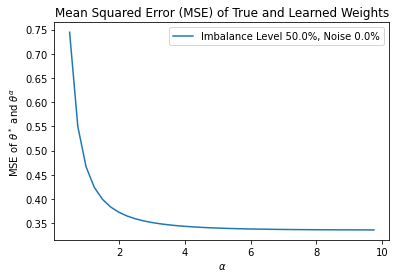

In [ ]:
from sklearn.metrics import mean_squared_error
mse_list = []
bayes_theta = np.array([-b/2,inter3[0], inter3[1]])
test_bayes_theta = np.array([-b/2,*(mu[1,:]-mu[0,:])])
print(bayes_theta)
for p in range(num_a):
    theta = thetas_super_storage[p,:]
    print(theta, alpha_vals[p])
    mse_list.append(mean_squared_error(theta, bayes_theta))

plt.figure(0)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'MSE of $\theta^*$ and $\theta^{\alpha}$')
plt.plot(alpha_vals, mse_list, label='Imbalance Level {imbalance:.1%}, Noise {noise:.1%}'.format(imbalance=pmix, noise=pflip))
plt.title('Mean Squared Error (MSE) of True and Learned Weights')
plt.legend()

np.save('mse_{imbalance}_{noise}.npy'.format(imbalance=pmix, noise=pflip),np.array(mse_list))

    

## plot the classification boundaries

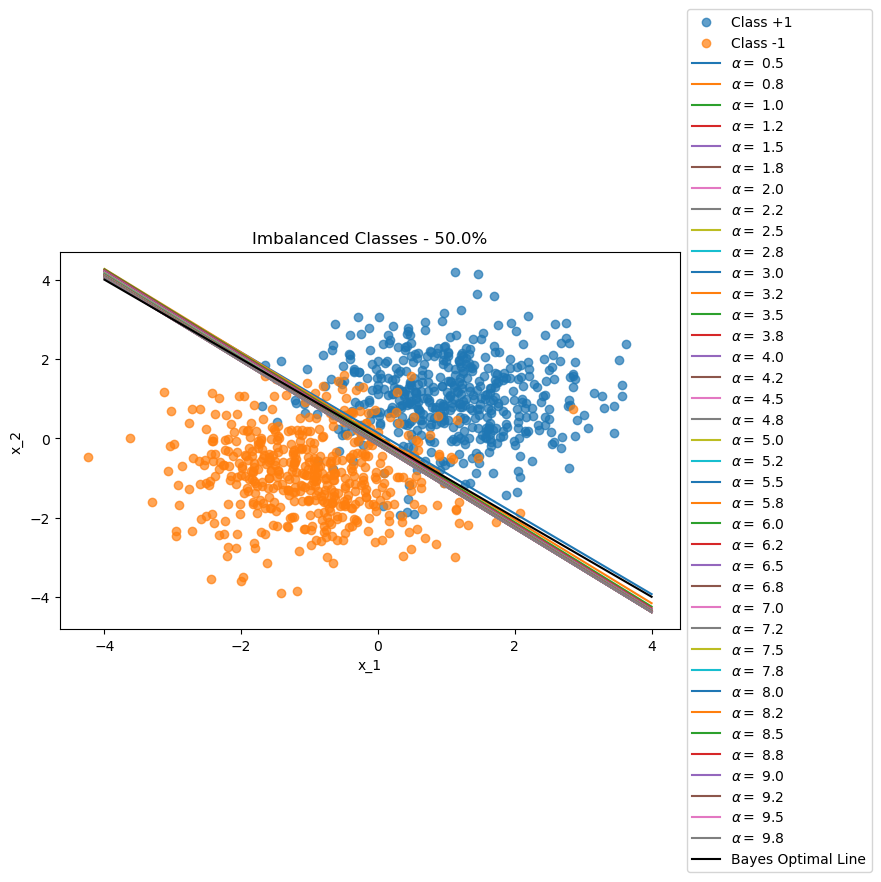

In [ ]:
# plt.figure(2)
plt.figure(figsize=(8,5), dpi=100)
plt.scatter(x_ones[:,0],x_ones[:,1], label='Class +1', alpha=0.7)
plt.scatter(x_zeros[:,0],x_zeros[:,1], label='Class -1', alpha=0.7)
for p in range(num_a):
    plt.plot(x1,x2[:,p] ,label=r'$\alpha =$ {alpha:.1f}'.format(alpha=alpha_vals[p]))

plt.plot(x1,x3, color='k', label='Bayes Optimal Line')
plt.title('Imbalanced Classes - {imbalance:.1%}'.format(imbalance=pmix))
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Determine accuracy of model against a test set

In [ ]:
n_test = int(1e5)
#keep pmix same
#pmix = 0.5
nmix = int(pmix*n_test)

[X_test, y_test] = gmm_generator_function(n_test, nmix, mu, sigma)

y_trans_test = (y_test + np.ones((n_test,1)))/2

# make predictions for each alpha 
bias = np.ones(n_test)
temp = np.zeros((n_test,3))
temp[:,0] = temp[:,0] + bias
temp[:,1] = temp[:,1] + X_test[:,0]
temp[:,2] = temp[:,1] + X_test[:,1]
counter = np.zeros((num_a,1))
y_preds = np.zeros((n_test,num_a))
for p in range(num_a):
  theta = thetas_super_storage[p,:]
  for q in range(n_test):
    y_hat = round(sigmoid(np.dot(np.squeeze(temp[q,:]),np.squeeze(theta))))
    y_preds[q,p] = y_hat
    if y_hat == y_trans_test[q]:
      counter[p] += 1
  counter[p] = counter[p]/n_test    

  print('The accuracy for alpha={:.2f} is: {:.2%}'.format(alpha_vals[p], float(counter[p])))


counter2 = 0
y_preds_bayes = np.zeros((n_test,1))

d = 1/inter3[1]
b = inter2 - inter1 + 2*np.log(pmix2/(1-pmix2))
for i in range(n_test):
    c = inter3[0]*X_test[i,0]
    if mu1 < 0:
        if X_test[i,1] >= d*(.5*b - c) :
            y_preds_bayes[i] = 1
        else:
            y_preds_bayes[i] = -1
    else:
        if X_test[i,1] < d*(.5*b - c) :
            y_preds_bayes[i] = 1
        else:
            y_preds_bayes[i] = -1

    if y_preds_bayes[i] == y_test[i]:
        counter2 += 1

print("The accuracy for Bayes' Optimal is: {:.2%}".format(counter2/n_test))
     



The accuracy for alpha=0.50 is: 90.87%
The accuracy for alpha=0.75 is: 90.79%
The accuracy for alpha=1.00 is: 90.73%
The accuracy for alpha=1.25 is: 90.72%
The accuracy for alpha=1.50 is: 90.72%
The accuracy for alpha=1.75 is: 90.72%
The accuracy for alpha=2.00 is: 90.72%
The accuracy for alpha=2.25 is: 90.72%
The accuracy for alpha=2.50 is: 90.72%
The accuracy for alpha=2.75 is: 90.72%
The accuracy for alpha=3.00 is: 90.72%
The accuracy for alpha=3.25 is: 90.72%
The accuracy for alpha=3.50 is: 90.72%
The accuracy for alpha=3.75 is: 90.72%
The accuracy for alpha=4.00 is: 90.72%
The accuracy for alpha=4.25 is: 90.71%
The accuracy for alpha=4.50 is: 90.72%
The accuracy for alpha=4.75 is: 90.72%
The accuracy for alpha=5.00 is: 90.71%
The accuracy for alpha=5.25 is: 90.70%
The accuracy for alpha=5.50 is: 90.70%
The accuracy for alpha=5.75 is: 90.70%
The accuracy for alpha=6.00 is: 90.71%
The accuracy for alpha=6.25 is: 90.71%
The accuracy for alpha=6.50 is: 90.70%
The accuracy for alpha=6.

## Determine MCC Scores

In [ ]:
from sklearn.metrics import matthews_corrcoef

MCC_alpha = np.zeros((num_a,1))
for p in range(num_a):
    #change to -1, 1
    pred = y_preds[:,p]
    pred[pred==0] = -1
    MCC_alpha[p] = matthews_corrcoef(y_test, pred)
    print('MCC score for alpha={:.2f} is: {:.4}'.format(alpha_vals[p],float(MCC_alpha[p])))

MCC_bayes = matthews_corrcoef(y_test, y_preds_bayes)
print('MCC score for Bayes optimal line is: {:.4}'.format(MCC_bayes))

MCC score for alpha=0.50 is: 0.8175
MCC score for alpha=0.75 is: 0.8158
MCC score for alpha=1.00 is: 0.8147
MCC score for alpha=1.25 is: 0.8143
MCC score for alpha=1.50 is: 0.8144
MCC score for alpha=1.75 is: 0.8145
MCC score for alpha=2.00 is: 0.8145
MCC score for alpha=2.25 is: 0.8145
MCC score for alpha=2.50 is: 0.8145
MCC score for alpha=2.75 is: 0.8144
MCC score for alpha=3.00 is: 0.8146
MCC score for alpha=3.25 is: 0.8145
MCC score for alpha=3.50 is: 0.8146
MCC score for alpha=3.75 is: 0.8144
MCC score for alpha=4.00 is: 0.8144
MCC score for alpha=4.25 is: 0.8144
MCC score for alpha=4.50 is: 0.8144
MCC score for alpha=4.75 is: 0.8145
MCC score for alpha=5.00 is: 0.8143
MCC score for alpha=5.25 is: 0.8142
MCC score for alpha=5.50 is: 0.8142
MCC score for alpha=5.75 is: 0.8142
MCC score for alpha=6.00 is: 0.8143
MCC score for alpha=6.25 is: 0.8143
MCC score for alpha=6.50 is: 0.8143
MCC score for alpha=6.75 is: 0.8142
MCC score for alpha=7.00 is: 0.8142
MCC score for alpha=7.25 is:

[0.35983384 0.03784411 0.29744092 ... 0.90975625 0.91466483 0.70763915]
[0.35983384 0.03784411 0.29744092 ... 0.90975625 0.91466483 0.70763915]
[0.3567133  0.02584987 0.28806565 ... 0.94040102 0.9428501  0.75587241]
[0.3567133  0.02584987 0.28806565 ... 0.94040102 0.9428501  0.75587241]
[0.35961198 0.02176504 0.28712093 ... 0.95223023 0.95403893 0.77959949]
[0.35961198 0.02176504 0.28712093 ... 0.95223023 0.95403893 0.77959949]
[0.36330454 0.01990246 0.28825268 ... 0.95812728 0.95970942 0.79313062]
[0.36330454 0.01990246 0.28825268 ... 0.95812728 0.95970942 0.79313062]
[0.36676073 0.01889325 0.28988928 ... 0.96160593 0.96308679 0.80184396]
[0.36676073 0.01889325 0.28988928 ... 0.96160593 0.96308679 0.80184396]
[0.36980525 0.01828584 0.29157594 ... 0.96388745 0.96531579 0.80793047]
[0.36980525 0.01828584 0.29157594 ... 0.96388745 0.96531579 0.80793047]
[0.3724534  0.01789414 0.29317206 ... 0.96549466 0.96689301 0.81243001]
[0.3724534  0.01789414 0.29317206 ... 0.96549466 0.96689301 0.81

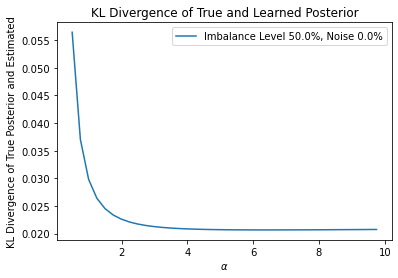

In [ ]:
from scipy.stats import entropy
true_posterior = (posterior(X_test, 0.5, mu[1,:], mu[0,:], sigma)).astype(float)
twisted_posterior = true_posterior
kl_list = []
bayes_estimated_posterior = sigmoid(X_test@bayes_theta[1:] + bayes_theta[0])
bayes_estimated_label = (bayes_estimated_posterior >0.5).astype(int)
y_preds_bayes[y_preds_bayes==-1] =0
for p in range(num_a):
    theta = thetas_super_storage[p,:]
    estimated_posterior = sigmoid(X_test@theta[1:] + theta[0])
    print(estimated_posterior)
    kl_list.append(entropy([twisted_posterior, 1-twisted_posterior], [estimated_posterior, 1-estimated_posterior], axis=0).mean())
    print(sigmoid(X_test@theta[1:] + theta[0]))
plt.figure(0)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'KL Divergence of True Posterior and Estimated')
plt.plot(alpha_vals, kl_list, label='Imbalance Level {imbalance:.1%}, Noise {noise:.1%}'.format(imbalance=pmix, noise=pflip))
plt.title('KL Divergence of True and Learned Posterior')
plt.legend()

np.save('kl_{imbalance}_{noise}_fixed_imbalance.npy'.format(imbalance=pmix, noise=pflip),np.array(kl_list))


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, penalty='none').fit(X, y.ravel())
lr_probs = clf.predict_proba(X_test)
lr_probs[:,1]

array([0.23060759, 0.00121086, 0.14786271, ..., 0.99332984, 0.99338922,
       0.88665755])

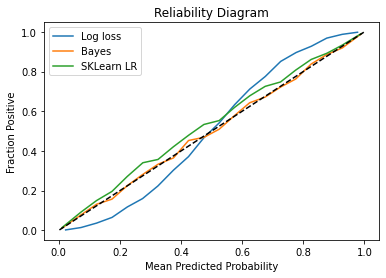

In [ ]:
from sklearn.calibration import calibration_curve
val = 37
y_pred_ll = sigmoid(X_test@thetas_super_storage[2,1:] + thetas_super_storage[2,0])
y_pred_2 = sigmoid(X_test@thetas_super_storage[val,1:] + thetas_super_storage[val,0])
y_pred_3 = sigmoid(X_test@thetas_super_storage[8,1:] + thetas_super_storage[8,0])
y_test[y_test==-1]=0
prob_true, prob_pred = calibration_curve(y_test, y_pred_ll, n_bins=20)
prob_true2, prob_pred2 = calibration_curve(y_test, y_pred_2, n_bins=20)
prob_true3, prob_pred3 = calibration_curve(y_test, y_pred_3, n_bins=20)
prob_true_lr, prob_pred_lr = calibration_curve(y_test, lr_probs[:,1], n_bins=20)
prob_true_bayes, prob_pred_bayes = calibration_curve(y_test, true_posterior, n_bins=20)
plt.plot(prob_pred, prob_true, label=r'$\alpha={alpha}$'.format(alpha=alpha_vals[2]))
#plt.plot(prob_pred2, prob_true2, label=r'$\alpha={alpha}$'.format(alpha=alpha_vals[val]))
#plt.plot(prob_pred3, prob_true3, label=r'$\alpha=2.5$')
plt.plot(prob_pred_bayes, prob_true_bayes, label=r'Bayes')
plt.plot(prob_pred_lr, prob_true_lr, label=r'SKLearn LR')
plt.plot(prob_true, prob_true, linestyle='dashed', color='black')
plt.title(r'Reliability Diagram')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction Positive')
plt.legend()

(array([3.54513173, 1.80817321, 1.13203366, 0.80896697, 0.63053014,
        0.52430822, 0.44389162, 0.39788212, 0.3812787 , 0.36747585,
        0.35507329, 0.37707783, 0.39908237, 0.4500929 , 0.50050331,
        0.59512284, 0.81036726, 1.11923101, 1.81037367, 3.54753223]),
 array([4.93046966e-05, 5.00389845e-02, 1.00028664e-01, 1.50018344e-01,
        2.00008024e-01, 2.49997704e-01, 2.99987383e-01, 3.49977063e-01,
        3.99966743e-01, 4.49956423e-01, 4.99946103e-01, 5.49935782e-01,
        5.99925462e-01, 6.49915142e-01, 6.99904822e-01, 7.49894502e-01,
        7.99884181e-01, 8.49873861e-01, 8.99863541e-01, 9.49853221e-01,
        9.99842901e-01]),
 <BarContainer object of 20 artists>)

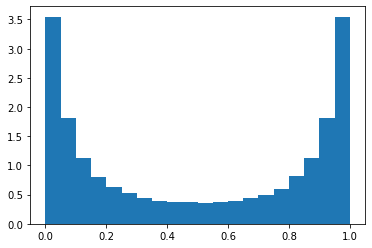

In [ ]:
plt.hist(y_pred_ll, bins=20, density=True)

(array([32566.,  5005.,  2928.,  2101.,  1571.,  1386.,  1279.,  1144.,
         1052.,  1058.,  1064.,  1046.,  1147.,  1259.,  1340.,  1645.,
         2018.,  2709.,  4922., 32760.]),
 array([4.34963249e-08, 5.00000278e-02, 1.00000012e-01, 1.49999996e-01,
        1.99999981e-01, 2.49999965e-01, 2.99999949e-01, 3.49999934e-01,
        3.99999918e-01, 4.49999902e-01, 4.99999887e-01, 5.49999871e-01,
        5.99999855e-01, 6.49999839e-01, 6.99999824e-01, 7.49999808e-01,
        7.99999792e-01, 8.49999777e-01, 8.99999761e-01, 9.49999745e-01,
        9.99999730e-01]),
 <BarContainer object of 20 artists>)

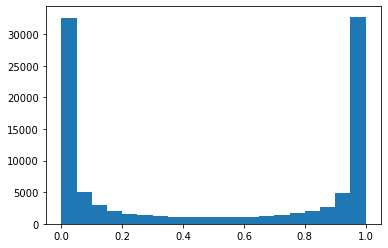

In [ ]:
plt.hist(true_posterior,bins=20)

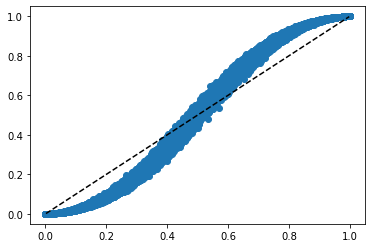

In [ ]:
plt.scatter(y_pred_ll, true_posterior)
plt.plot(prob_true, prob_true, linestyle='dashed', color='black')